In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from deconv import *

In [2]:
%matplotlib notebook

## Example Bipolar Data (2021_06_30)
### In each table:                                                             
* column 1 & 2 : static spot stimulus_200um (two trials)                       
* column 3 & 4 : snake stimulus_500um/s (two trials)                           
* column 5 & 6 : moving spot stimulus_500um/s (two trials)                     

**Scan rate for all**: 58.25 Hz                                                
**ROI size**: 5 um.

In [5]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_06_30/waveforms/")
stim_labels = ["static_spot", "snake", "moving_spot"]
n_trials = 2
dt = 1 / 58.25

roi_data = {
    d: np.stack(
        [
            pd.read_csv(os.path.join(data_path, d, f), skiprows=1).values.T
            for f in os.listdir(os.path.join(data_path, d))
        ], 
        axis=0
    ) 
    for d in ["DD", "PD"]
}

recs = {
    d: {
        s: rois[:, i * n_trials:i * n_trials + n_trials]
        for i, s in enumerate(stim_labels)
    }  
    for d, rois in roi_data.items()
}

avg_recs = {
    d: {s: np.mean(rs, axis=1) for s, rs in rois.items()} 
    for d, rois in recs.items()
}

rec_xaxis = np.arange(avg_recs["DD"]["snake"].shape[-1]) * dt

<IPython.core.display.Javascript object>


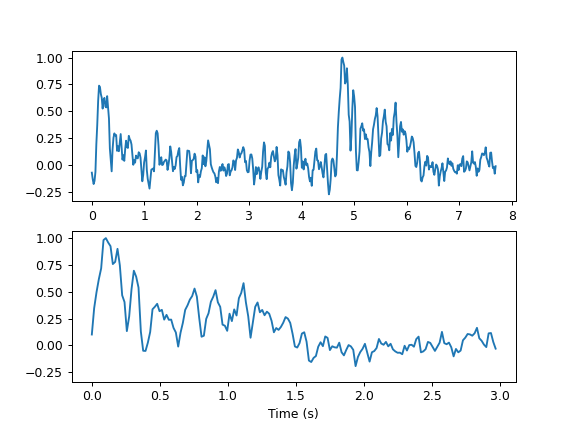

In [92]:
depth = "PD"
roi_idx = 0
stm = "snake"
ex = avg_recs[depth][stm][roi_idx] / np.max(avg_recs[depth][stm][roi_idx])
event_dur = 3
event_pts = int(3 / dt)
rise_start = find_rise_bsln(ex, bsln_end=150, step=1)
ex_event = ex[rise_start:rise_start + event_pts]

ex_fig, ex_ax = plt.subplots(2, sharey=True)
ex_ax[0].plot(rec_xaxis, ex)
ex_ax[1].plot(np.arange(len(ex_event)) * dt, ex_event)
ex_ax[1].set_xlabel("Time (s)")
ex_fig.show()

<IPython.core.display.Javascript object>


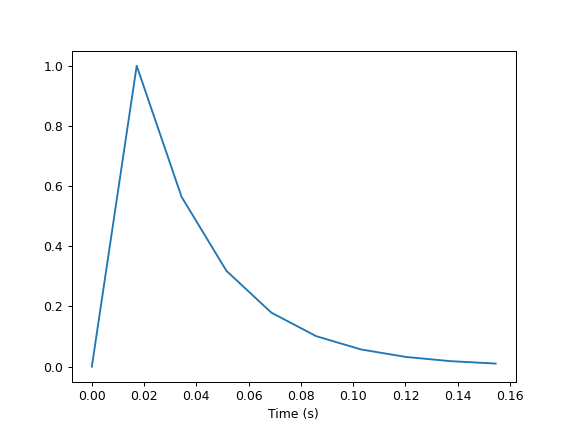

In [93]:
tau1 = 2 # ms
tau2 = 30
n_pts = 10

dummy = BiexpFitter(1, 10, norm_amp=True)
dummy_fit = dummy.model(
    t=np.arange(n_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]

fit_xaxis = np.arange(n_pts) * dt

biexp_fig, biexp_ax = plt.subplots(1)
biexp_ax.plot(fit_xaxis, dummy_fit)
biexp_ax.set_xlabel("Time (s)")
biexp_fig.show()

In [94]:
ev = ex
# ev = ex_event
qse = 2 * np.var(ev) / np.mean(ev)
# qse = np.var(ev) / np.mean(ev)
# qse = 0.4
qse = 0.97506  # from PD snake
scaled_fit = dummy_fit * qse
ev_xaxis = np.arange(len(ev)) * dt
dummy_fft = np.fft.rfft(scaled_fit, n=len(ev))
event_fft = np.fft.rfft(ev)
inv = np.fft.irfft(event_fft / dummy_fft)
deconv = np.convolve(inv, scaled_fit)

print("qse = %.5f" % qse)

qse = 0.97506


<IPython.core.display.Javascript object>


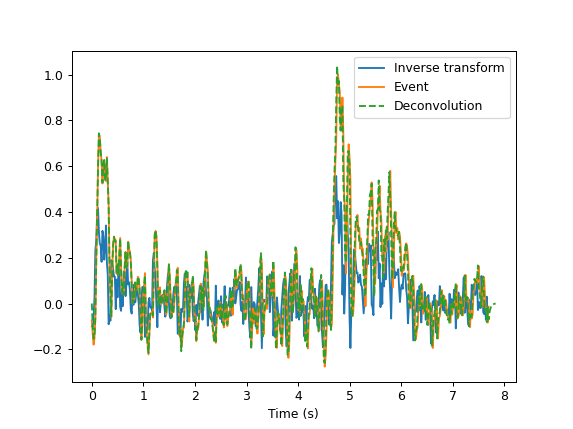

In [95]:
inv_fig, inv_ax = plt.subplots(1)
inv_ax.plot(ev_xaxis[:-1], inv, label="Inverse transform")
inv_ax.plot(ev_xaxis, ev, label="Event")
inv_ax.plot(np.arange(len(deconv)) * dt, deconv, label="Deconvolution", linestyle="--")
inv_ax.set_xlabel("Time (s)")
inv_ax.legend()
inv_fig.show()

In [96]:
bin_t = 0.05  # s
sz = int(bin_t / dt)
bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
binned = bin_mean(inv, sz)
print("points per bin:", sz)
print("time per bin: %.2fms" % (sz * dt * 1000))

points per bin: 2
time per bin: 34.33ms


<IPython.core.display.Javascript object>


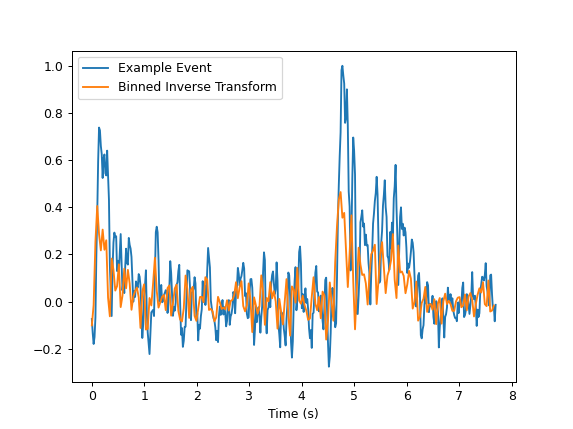

In [101]:
bin_fig, bin_ax = plt.subplots(1)
bin_ax.plot(ev_xaxis, ev, label="Example Event")
bin_ax.plot(bin_edges, binned, label="Binned Inverse Transform")
bin_ax.set_xlabel("Time (s)")
bin_ax.legend()
bin_fig.show()

<IPython.core.display.Javascript object>


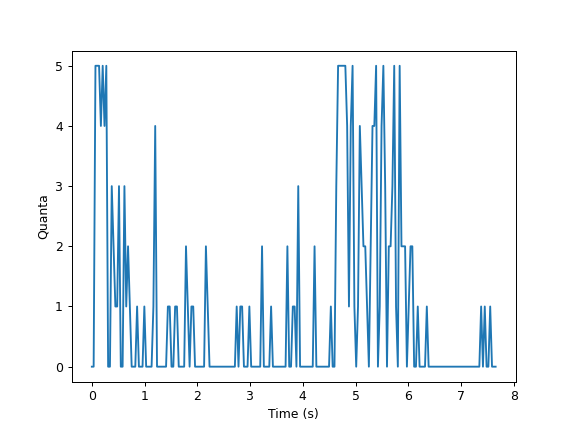

In [108]:
# quanta = raster(binned, thresh=0.4, max_q=5)
ceiling = 0.8
max_q = 8
quanta_scaled_fit = scaled_fit / max_q
quanta = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=5)
# quantal_sum = sum_quanta(quanta, bin_edges, scaled_fit, dt)
quantal_sum = sum_quanta(quanta, bin_edges, quanta_scaled_fit, dt)
quantal_sum_xaxis = np.arange(len(quantal_sum)) * dt

raster_fig, raster_ax = plt.subplots(1)
raster_ax.plot(bin_edges, quanta)
raster_ax.set_xlabel("Time (s)")
raster_ax.set_ylabel("Quanta")
raster_fig.show()

<IPython.core.display.Javascript object>


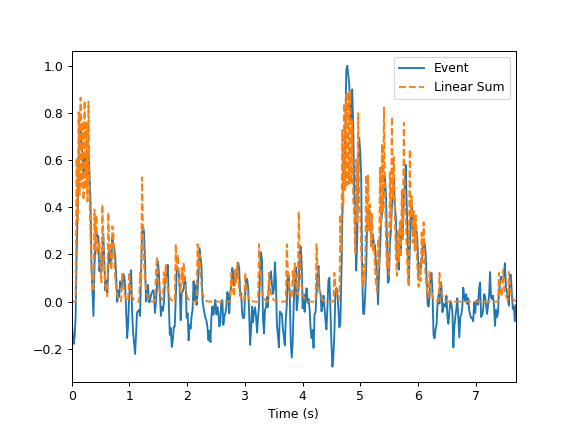

In [109]:
dequanta_fig, dequanta_ax = plt.subplots(1)
dequanta_ax.plot(ev_xaxis, ev, label="Event")
dequanta_ax.plot(quantal_sum_xaxis, quantal_sum, label="Linear Sum", linestyle="--")
dequanta_ax.set_xlim(0, np.max(ev_xaxis))
dequanta_ax.set_xlabel("Time (s)")
dequanta_ax.legend()
dequanta_fig.show()

## TODO:
* calculate QSE based on static spot PD recordings. Use the average from that over ROIs or something, then use that in the rest of the analysis (can show scatter of that).
* compare max number of quanta (MSE, what gets the best fit, show figure)
* generate figures with many examples of this method of estimating quantal events
 * proximal vs distal
 * each stimuli
 * different ROIs
 * averages vs trials